In [3]:
from collections import Counter

import category_encoders as ce
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from create_dataset import ds

# Feature engineering

Adding columns or transform existing columns
- this includes the target (target transformation)

## How can I generate features?

Domain knowledge
- use business insight -> features

Exploratory data analysis

Build features from features
- ratios
- polynomials
- log / exponentials / sigmoids
- Fourier / Laplace transforms

## Data leakage

Feature available during training that isn't available during testing / production time

Duplicates in the train & test set

Training / learning statistics from the test set
- common mistake to refit normalization / standardization

Feature engineering can often cause data leakage
- mean target encoding on the entire dataset, before splitting test & train

## Nominal vs ordinal

Nominal (no order) versus ordinal (order)

Some methods place order onto a nominal series during the encoding

## Transform from continuous to categorical

On the target 
- moving from a regression to classification problem 
- key thing to ask - how do we use our prediction in our business problem

On features 
- removes noise (& maybe signal)

In [4]:
ds

,customers-category,contract-length,location
0,A,10.0,us
1,A,9.0,us
2,A,9.0,us
3,B,20.0,nz
4,B,30.0,NaN
5,B,10.0,nz
6,C,NaN,nz
7,C,5.0,nz
8,C,NaN,us
9,NaN,1.0,nz


In [5]:
pd.cut(ds.loc[:, 'contract-length'].fillna(0), bins=4)

0      (-0.1, 25.0]
1      (-0.1, 25.0]
2      (-0.1, 25.0]
3      (-0.1, 25.0]
4      (25.0, 50.0]
5      (-0.1, 25.0]
6      (-0.1, 25.0]
7      (-0.1, 25.0]
8      (-0.1, 25.0]
9      (-0.1, 25.0]
10    (75.0, 100.0]
Name: contract-length, dtype: category
Categories (4, interval[float64, right]): [(-0.1, 25.0] < (25.0, 50.0] < (50.0, 75.0] < (75.0, 100.0]]

## Dealing with categorical variables

Machine always think in numbers
- all categorical features need to be transformed into numbers at somepoint
- most ML algorithms get upset if you don't do it - some will do it on the fly

## One hot encoding

- curse of dimensionality makes dimensionality increase exponential
- lose the explicit relationship of the feature (model now just sees a lot of columns, and has to learn their relationship)

There are a few ways to do one-hot encoding in the Python
- `sklearn.preprocessing.OneHotEncoder()`
- `pd.get_dummies()`

Recommend `sklearn.preprocessing.OneHotEncoder()`
- creates a stateful transformer that can be reused (i.e. on the test data)
- using `pd.get_dummies`, you are hoping that the columns will be encoded in the same way at test time

In [6]:
from sklearn.preprocessing import OneHotEncoder

#  note that I use a missing value token here
cat = ds.loc[:, 'customers-category'].to_frame().fillna('missing')

#  will by default return a sparse matrix - you can turn this off
enc = OneHotEncoder(sparse=False)
enc.fit_transform(cat)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

## Label encoding

- `0, 1, 2, 3`
- is an ordinal encoding - even if feature is not ordinal, you are imposing this structure on the data

Decision trees sort the data based on the feature being split on
- this makes the decision boundary meaningful
- inherently ordinal

In [7]:
enc = LabelEncoder()
enc.fit_transform(cat)

/Users/samson.afolabi/opt/anaconda3/envs/f2m/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 2])

## Mean encode

- put the training data average for the target for that class
- could also use other statistics like median, quantiles or variance

The code below will mean encode a categorical feature using the average of another column (often the target):

In [8]:
def mean_encode(data, col, on):
    group = data.groupby(col).mean()
    data.loc[:, col+'-original'] = data.loc[:, col]
    mapper = {k: v for k, v in zip(group.index, group.loc[:, on].values)}

    data.loc[:, col] = data.loc[:, col].replace(mapper)
    data.loc[:, col].fillna(value=np.mean(data.loc[:, col]), inplace=True)
    return data


def test_mean_encoding():
    store1 = pd.DataFrame(
        {'store': ['A'] * 3,
         'Sales': [100, 200, 300],
         'noise': [0, 0, 0]}
    )

    store2 = pd.DataFrame(
        {'store': ['B'] * 3,
         'Sales': [10, 20, 30],
         'noise': [0, 0, 0]}
    )

    data = pd.concat([store1, store2], axis=0)
    data = mean_encode(data, col='store', on='Sales')
    np.testing.assert_array_equal(
        data.loc[:, 'store'], np.array([200, 200, 200, 20, 20, 20])
    )
    
test_mean_encoding()
data = mean_encode(ds.copy(), 'customers-category', 'contract-length')
data.drop(['contract-length', 'location'], axis=1)

,customers-category,customers-category-original
0,9.333333,A
1,9.333333,A
2,9.333333,A
3,20.000000,B
4,20.000000,B
5,20.000000,B
6,52.500000,C
7,52.500000,C
8,52.500000,C
9,29.800000,NaN


## Mean & frequency encoding

If we have a category with only a few samples, the mean we encode will be higher variance
- we can tell the model this by encoding the weighted average of the overall mean & the mean of this category
- we trust the mean encoding less if we have less samples
- requires a hyperparameter $\lambda$
- function that turns a category into a weight

$$ \lambda(category) * \mu(category) + (1 - \lambda(category)) * mean(data) $$

A simple choice of $\lambda$ is a frequentist probability

$$\lambda(category) = \frac{freq(category)}{freq(all categories)}$$

### Practical

Implement mean & frequency encoding

## Binary encoding

Encoding the string using it's binary (0110100 etc) representation

In Python we can do this using the `bin()` builtin:

In [9]:
bin(4)

'0b100'

The `category_encoders` library can do this for us:

In [10]:
data = ['A', 'BB', 'B', 'A', 'C', 'D', 'A', 'E']

enc = ce.BinaryEncoder()

print('{} classes'.format(len(set(data))))

pd.concat([enc.fit_transform(data), pd.DataFrame(data, columns=['data'])], axis=1)

6 classes


,0_0,0_1,0_2,data
0,0,0,1,A
1,0,1,0,BB
2,0,1,1,B
3,0,0,1,A
4,1,0,0,C
5,1,0,1,D
6,0,0,1,A
7,1,1,0,E


## Frequency encoding

Encode the categorical feature based on their relative frequency
- probability of seeing this category
- tell the model about rare categories
- but you can't distinguish categories with the same frequency (unlikely in very large datasets)

In [11]:
data = ['A', 'B', 'A', 'C', 'D', 'A', 'E']
counter = Counter(data)
freq_enc = [counter[x] / len(data) for x in data]

pd.DataFrame(
    {'data': data,
     'freq_enc': freq_enc}
)

,data,freq_enc
0,A,0.428571
1,B,0.142857
2,A,0.428571
3,C,0.142857
4,D,0.142857
5,A,0.428571
6,E,0.142857


### Others

- hint your model as much as possible.

In [14]:
data = pd.DataFrame(
    {'sales': [10, 50, 100], 'year': [2012, 2013, 2014]}
)

data.loc[:, 'last-year-sales-feature'] = data.loc[:, 'sales'].shift()
data.loc[:, 'model-target'] = data.loc[:, 'sales'].diff()

data

,sales,year,last-year-sales-feature,model-target
0,10,2012,NaN,NaN
1,50,2013,10.0,40.0
2,100,2014,50.0,50.0


## Dimensionality reduction

### PCA & t-SNE

Both forms of dimensionality reduction, that can create new columns
- these can sit alongside or replace the high dimensional data

### Clustering

Can be used to create a new feature:

In [15]:
data = pd.DataFrame([np.random.uniform(0, x, 1000) for x in range(1, 10)]).T

mdl = KMeans(3)
mdl.fit(data)
data.loc[:, 'cluster'] = mdl.labels_

data.head()

,0,1,2,3,4,5,6,7,8,cluster
0,0.337231,1.778547,0.071259,2.956482,4.117714,1.232833,2.452119,2.564192,2.335427,2
1,0.742291,0.962601,1.680845,0.696040,4.561649,0.501900,2.134662,0.755031,5.182304,2
2,0.400586,1.332415,2.169164,2.222380,2.906531,4.389324,2.815613,6.989672,0.156685,1
3,0.253136,1.982072,2.638005,2.543806,1.139170,5.868670,1.841247,0.615939,7.033612,0
4,0.349905,1.360423,0.826688,2.816389,3.526311,0.823591,2.192495,6.856525,8.483183,0


## Datetime

### Month, year, day columns

These can then be either be label / one-hot encoded

In [16]:
data = pd.DataFrame(
    {'date': pd.date_range('01-01-2018', '02-01-2018', freq='1h')}
)

data.loc[:, 'month'] = data.loc[:, 'date'].dt.month
data.loc[:, 'minute'] = data.loc[:, 'date'].dt.minute

data.head()

,date,month,minute
0,2018-01-01 00:00:00,1,0
1,2018-01-01 01:00:00,1,0
2,2018-01-01 02:00:00,1,0
3,2018-01-01 03:00:00,1,0
4,2018-01-01 04:00:00,1,0


### Cyclical datetime features

Encoding cyclical continuous features - [blog post](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/)

<AxesSubplot:xlabel='sin', ylabel='cos'>

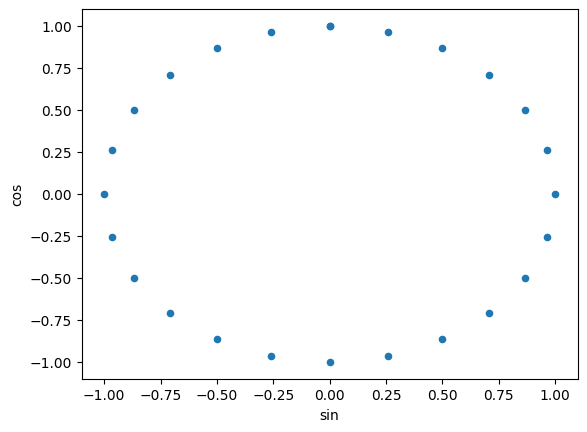

In [17]:
hours_in_day = 24

def transform_hourly(self, x):
    h = x.index.hour

    sin = np.sin(2 * np.pi * h / self.hours_in_day)
    cos = np.cos(2 * np.pi * h / self.hours_in_day)

    out = pd.DataFrame(index=x.index)
    out.loc[:, 'sin_h'] = sin
    out.loc[:, 'cos_h'] = cos
    return out


def transform_hh(self, x):
    hh = x.index.hour + (x.index.minute / 60)

    sin = np.sin(2 * np.pi * hh / self.hours_in_day)
    cos = np.cos(2 * np.pi * hh / self.hours_in_day)

    out = pd.DataFrame(index=x.index)
    out.loc[:, 'sin_hh'] = sin
    out.loc[:, 'cos_hh'] = cos
    return out


def transform(x, max_value):
    sin = np.sin(2 * np.pi * x / max_value)
    cos = np.cos(2 * np.pi * x / max_value)

    out = pd.DataFrame()
    out.loc[:, 'sin'] = sin
    out.loc[:, 'cos'] = cos

    return out

rng = pd.DataFrame(index=pd.date_range('01-01-2020', '01-02-2020', freq='1h'))
df = transform(rng.index.hour, 24)
df.plot('sin', 'cos', kind='scatter')

In [18]:
df

,sin,cos
0,0.000000e+00,1.000000e+00
1,2.588190e-01,9.659258e-01
2,5.000000e-01,8.660254e-01
3,7.071068e-01,7.071068e-01
4,8.660254e-01,5.000000e-01
5,9.659258e-01,2.588190e-01
6,1.000000e+00,6.123234e-17
7,9.659258e-01,-2.588190e-01
8,8.660254e-01,-5.000000e-01
9,7.071068e-01,-7.071068e-01


## Time series decomposition

Seasonality, trend can become features

More important than other areas to ask the question
- what will I have available at test time?
- example of weather versus weather forecasts

## NLP

Bag of words, tfidf

Tokenization
- harder than splitting on whitespace!
- ngrams
- NLTK, SpaCy

Word / doc embeddings
- word to vec

### Part of speech tagging with SpaCy

A simplified form of this is commonly taught to school-age children, in the identification of words as nouns, verbs, adjectives, adverbs, etc.

https://spacy.io/usage/linguistic-features

https://spacy.io/api/token

**Need to run**:
```bash
$ python -m spacy download en_core_web_sm
```

In [21]:
def find_ents(doc, verbose=False):
    if verbose:
        print(doc)
        print('---')
        
    doc = nlp(doc)
    ents = []
    for token in doc:
        
        if verbose:
            print({
                'text': token.text,
                'coarse POS': token.pos_,
                'fine POS': token.tag_,
                'syntatic dependency relation': token.dep_,
                'stop': token.is_stop
            })
        if token.pos_ == 'PROPN':
            ents.append(token)
            
    return doc, ents

In [22]:
nlp = spacy.load('en_core_web_sm') 
doc, ents = find_ents("Apple is looking at buying U.K. startup for $1 billion to prevent coronavirus")
ents

[Apple, U.K.]

Possible for a single word to have a different part of speech tag in different sentences based on different contexts

- I love you vs. Lets make love

In [23]:
doc, ents = find_ents("I care for you", verbose=True)

I care for you
---
{'text': 'I', 'coarse POS': 'PRON', 'fine POS': 'PRP', 'syntatic dependency relation': 'nsubj', 'stop': True}
{'text': 'care', 'coarse POS': 'VERB', 'fine POS': 'VBP', 'syntatic dependency relation': 'ROOT', 'stop': False}
{'text': 'for', 'coarse POS': 'ADP', 'fine POS': 'IN', 'syntatic dependency relation': 'prep', 'stop': True}
{'text': 'you', 'coarse POS': 'PRON', 'fine POS': 'PRP', 'syntatic dependency relation': 'pobj', 'stop': True}


In [24]:
doc, ents = find_ents("He needs a lot of care", verbose=True)

He needs a lot of care
---
{'text': 'He', 'coarse POS': 'PRON', 'fine POS': 'PRP', 'syntatic dependency relation': 'nsubj', 'stop': True}
{'text': 'needs', 'coarse POS': 'VERB', 'fine POS': 'VBZ', 'syntatic dependency relation': 'ROOT', 'stop': False}
{'text': 'a', 'coarse POS': 'DET', 'fine POS': 'DT', 'syntatic dependency relation': 'det', 'stop': True}
{'text': 'lot', 'coarse POS': 'NOUN', 'fine POS': 'NN', 'syntatic dependency relation': 'dobj', 'stop': False}
{'text': 'of', 'coarse POS': 'ADP', 'fine POS': 'IN', 'syntatic dependency relation': 'prep', 'stop': True}
{'text': 'care', 'coarse POS': 'NOUN', 'fine POS': 'NN', 'syntatic dependency relation': 'pobj', 'stop': False}


## Augmentation

Common in computer vision
- rotation etc

SMOTE
- synthetic data

## References

Gabby Shklovsky - Random Forests Best Practices for the Business World - PyData NYC 2017 [youtube](https://www.youtube.com/watch?v=E7VLE-U07x0) - [slides](https://www.youtube.com/redirect?q=https%3A%2F%2Fwww.slideshare.net%2FPyData%2Frandom-forests-best-practices-for-the-business-world&redir_token=HgV_RBYb_uD_jYV6nYygn8RpyKR8MTU2OTkwODE2N0AxNTY5ODIxNzY3&v=E7VLE-U07x0&event=video_description)

Art of Feature Engineering for Data Science - Nabeel Sarwar - [youtube](https://youtu.be/leTyvBPhYzw)

Feature Engineering with H2O - Dmitry Larko, Senior Data Scientist, H2O.ai - [youtube](https://youtu.be/irkV4sYExX4)

[Building Machine Learning Powered Applications: Going from Idea to Product](https://www.amazon.com/Building-Machine-Learning-Powered-Applications/dp/149204511X)

[Datacamp categorical data tutorial](https://www.datacamp.com/community/tutorials/categorical-data)

[Smarter Ways to Encode Categorical Data for Machine Learning](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159)

[Vincent Warmerdam: Winning with Simple, even Linear, Models | PyData London 2018](https://www.youtube.com/watch?v=68ABAU_V8qI)

[Why giving your algorithm ALL THE FEATURES does not always work - Thomas Huijskens](https://www.youtube.com/watch?v=JsArBz46_3s)

[Feature Engineering - Elite Data Science](https://elitedatascience.com/feature-engineering)

[Feature Engineering for ML](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)

# Others

See *Feature Engineering with H2O - Dmitry Larko, Senior Data Scientist, H2O.ai - [youtube](https://youtu.be/irkV4sYExX4)*


*Gabby Shklovsky - Random Forests Best Practices for the Business World - PyData NYC 2017 [youtube](https://www.youtube.com/watch?v=E7VLE-U07x0) - [slides](https://www.youtube.com/redirect?q=https%3A%2F%2Fwww.slideshare.net%2FPyData%2Frandom-forests-best-practices-for-the-business-world&redir_token=HgV_RBYb_uD_jYV6nYygn8RpyKR8MTU2OTkwODE2N0AxNTY5ODIxNzY3&v=E7VLE-U07x0&event=video_description)*

*Gabby Shklovsky - Random Forests Best Practices for the Business World - PyData NYC 2017 [youtube](https://www.youtube.com/watch?v=E7VLE-U07x0) - [slides](https://www.youtube.com/redirect?q=https%3A%2F%2Fwww.slideshare.net%2FPyData%2Frandom-forests-best-practices-for-the-business-world&redir_token=HgV_RBYb_uD_jYV6nYygn8RpyKR8MTU2OTkwODE2N0AxNTY5ODIxNzY3&v=E7VLE-U07x0&event=video_description)*